# Load the MLFlow model locally and try predictions

## Prerequisites

1. You need to have run successfully the training notebook related to this model, available in this same folder, where at the end of the notebook, after training the model, it downloads the 'artifacts' with the MLFlow model folder ("./artifact_downloads/outputs/mlflow-model").

2. Create a conda environment with the 'conda.yaml' file provided within the "mlflow-model" folder, doing like the following:
   1. if you are running this notebook on a windows machine, Please remove "Pycocotools" and "recordclass" lines from conda.yaml and have c++ build tools( https://visualstudio.microsoft.com/visual-cpp-build-tools/ ) installed before running the below steps

   1. (base) /> conda env create --file conda.yaml --name automl-model-image-multicls-cls-env
   
   1. (base) /> conda activate automl-model-image-multicls-cls-env
   
   1. (automl-model-image-multicls-cls-env) /> conda install jupyter nb_conda

3. Run Jupyter and make sure you are using the related 'automl-model-image-multicls-cls-env' Kernel.

4. Run this notebook.

If the MLFlow model files were downloaded successfully by the training notebook, you should see the files here.

In [8]:
import os

# Local dir where you have downloaded and saved the artifacts
local_dir = "./"

mlflow_model_dir = os.path.join(local_dir, "mlflow-model-folder", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['code',
 'conda.yaml',
 'data',
 'LICENSE',
 'MLmodel',
 'python_env.yaml',
 'requirements.txt',
 'train_label_list.npy']

In [9]:
# Change to a different location if you downloaded data at a different location
dataset_parent_dir = "./"
dataset_name = "fridgeObjects"

os.listdir(os.path.join(dataset_parent_dir, dataset_name, "milk_bottle"))

['100.jpg',
 '101.jpg',
 '65.jpg',
 '66.jpg',
 '67.jpg',
 '68.jpg',
 '69.jpg',
 '70.jpg',
 '71.jpg',
 '72.jpg',
 '73.jpg',
 '74.jpg',
 '75.jpg',
 '76.jpg',
 '77.jpg',
 '78.jpg',
 '79.jpg',
 '80.jpg',
 '81.jpg',
 '82.jpg',
 '83.jpg',
 '84.jpg',
 '85.jpg',
 '86.jpg',
 '87.jpg',
 '88.jpg',
 '89.jpg',
 '90.jpg',
 '91.jpg',
 '92.jpg',
 '93.jpg',
 '94.jpg',
 '95.jpg',
 '96.jpg',
 '97.jpg',
 '98.jpg',
 '99.jpg']

### Load the test data into a Pandas DataFrame

Load some test images into a Pandas DataFrame in order to try some predictions with it.

In [10]:
test_image_paths = [
    os.path.join(dataset_parent_dir, dataset_name, "can", "1.jpg"),
    os.path.join(dataset_parent_dir, dataset_name, "carton", "33.jpg"),
    os.path.join(dataset_parent_dir, dataset_name, "milk_bottle", "99.jpg"),
    os.path.join(dataset_parent_dir, dataset_name, "water_bottle", "120.jpg"),
]

In [11]:
import pandas as pd
import base64


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

images=[
        base64.encodebytes(read_image(image_path)).decode('utf-8')
        for image_path in test_image_paths
    ]

import numpy
train_label_list = numpy.load(mlflow_model_dir + "/train_label_list.npy")
captions = ','.join(train_label_list)
data = [[img, ""] for img in images]
len(data)
data
data[0][1] = captions
data
len(data)
test_df = pd.DataFrame(
    data=data,
    columns=["image", "text"],
)
test_df

,image,text
0,/9j/4AAQSkZJRgABAQEASABIAAD/4XlnRXhpZgAASUkqAA...,"can,carton,milk_bottle,water_bottle"
1,/9j/4AAQSkZJRgABAQEASABIAAD/4XvwRXhpZgAASUkqAA...,
2,/9j/4AAQSkZJRgABAQEASABIAAD/4aYSRXhpZgAASUkqAA...,
3,/9j/4AAQSkZJRgABAQEASABIAAD/4Y+MRXhpZgAASUkqAA...,


## Load the best model in memory

Load the model using MLflow flavor. Check MLmodel under the downloaded folder (artifact_downloads/outputs/mlflow-model). For this particular example (and for AutoML for Images scenario), MLmodel file will describe python_function flavor. We show how to load model using pyfunc flavor. For more information on MLflow flavors, visit: https://www.mlflow.org/docs/latest/models.html#storage-format

Loading the models locally assume that you are running the notebook in an environment compatible with the model. The list of dependencies that is expected by the model is specified in the MLFlow model produced by AutoML (in the 'conda.yaml' file within the mlflow-model folder).

In [12]:
import azureml.evaluate.mlflow as mlflow

In [13]:
# Way #1: Get the MLFlow model from the downloaded MLFlow model files
# pyfunc_model = mlflow.pyfunc.load_model(mlflow_model_dir)
reloaded_task_type, r_model, r_processor, r_config = mlflow.hftransformers.load_model(mlflow_model_dir)
print(type(r_processor))
print(type(r_config))
print(type(r_model))

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


<class 'transformers.models.clip.processing_clip.CLIPProcessor'>
<class 'transformers.models.clip.configuration_clip.CLIPConfig'>
<class 'transformers.models.clip.modeling_clip.CLIPModel'>


In [18]:
# # Make the predictions
# result = pyfunc_model.predict(test_df).to_json(orient="records")
# result
from hf_test_predict import predict

result = predict(test_df, "image-classification", r_model, r_processor)
result

,probs,labels
0,"[0.2795253396034241, 0.4253213703632355, 0.019...","can,carton,milk_bottle,water_bottle"
1,"[0.009538884274661541, 0.958022952079773, 0.03...","can,carton,milk_bottle,water_bottle"
2,"[0.0021344651468098164, 0.021410757675766945, ...","can,carton,milk_bottle,water_bottle"
3,"[0.0025448224041610956, 0.0011732083512470126,...","can,carton,milk_bottle,water_bottle"


## Visualize detections
Now that we have scored test images, we can visualize the prediction for the first image.

3
0.936778724193573
water_bottle (0.937)


<Figure size 1800x1200 with 0 Axes>

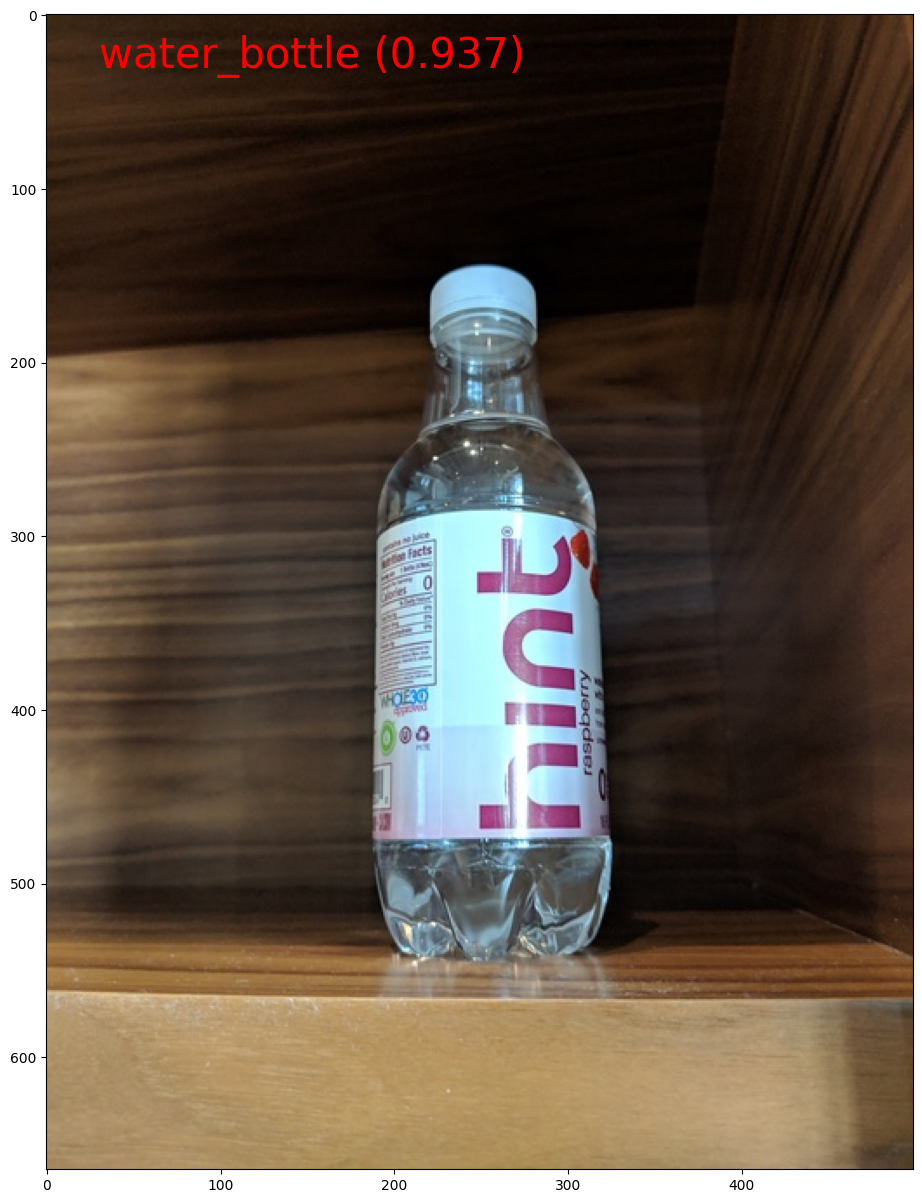

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

sample_image = test_image_paths[3]
prediction = result

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

label_index = np.argmax(prediction["probs"][3])
label = prediction["labels"][3].split(',')[label_index]
conf_score = prediction["probs"][3][label_index]

print(label_index)
print(conf_score)
display_text = f"{label} ({round(conf_score, 3)})"
print(display_text)

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.